<a href="https://colab.research.google.com/github/sim-so/HandsOnML/blob/main/14_CNN_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14 CNN 연습문제

## 9. 나만의 CNN으로 MNIST 해결하기
최고 성능이 99.91인 SOTA 모델을 만들어보자. >
[Paper](https://paperswithcode.com/paper/an-ensemble-of-simple-convolutional-neural)
- 단순 CNN 모델
    - 매 Conv Layer마다 BatchNormalization
    - 3개 모델의 kernel size를 각 3, 5, 7로
- 데이터 증강
- 모델 앙상블

### Load Dataset

In [1]:
!python -m pip install tensorflow-gpu==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.4/498.4 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 40.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successf

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(33)
tf.random.set_seed(33)

In [3]:
from tensorflow.keras import datasets
(X_train_full, y_train_full), (X_test, y_test) = datasets.mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [4]:
X_train_full.shape

(60000, 28, 28)

### Preprocessing
- [0, 255]의 숫자를 [0, 1] 범위로 normalization
    - 논문에서는 [-1, 1]


In [5]:
from sklearn.model_selection import train_test_split

X_train_full = X_train_full / 255.
X_test = X_test / 255.

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.1, shuffle=True, stratify=y_train_full)

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

### Data Augmentation
- 데이터 증강하여 Train set으로 사용
    - 시계방향 혹은 반시계방향으로 20도 회전
    - 상하좌우 중 임의의 방향으로 20% 이동
- Training 중 새로 변형하여 매 epoch 마다 새로운 데이터를 학습하게 함

In [6]:
# transform example
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import RandomRotation

transforms = Sequential(name="transforms_nearest")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="nearest"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="nearest"))           # almost 20 degree
transforms.compile()

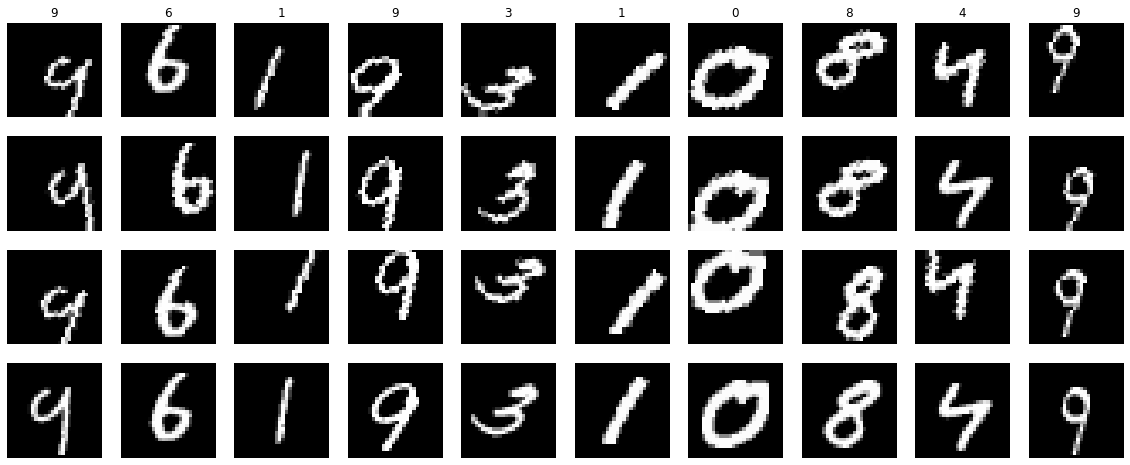

In [7]:
n_samples = 10
plt.figure(figsize=(20, 8))
for i in range(3):
    augmented_input_samples = transforms(X_train[:n_samples], training=True)
    for j, sample in enumerate(augmented_input_samples, 1):
        plt.subplot(4, n_samples, 10*i+j)
        if i == 0:
            plt.title(f"{y_train[j-1]}")
        plt.imshow(sample.numpy().squeeze(-1), cmap="gray")
        plt.axis("off")
for i in range(n_samples):
    plt.subplot(4, n_samples, 31+i)
    plt.imshow(X_train[i].squeeze(-1), cmap="gray")
    plt.axis("off")
plt.show()

In [8]:
transforms = Sequential(name="transforms_bilinear")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="bilinear"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="bilinear"))           # almost 20 degree
transforms.compile()

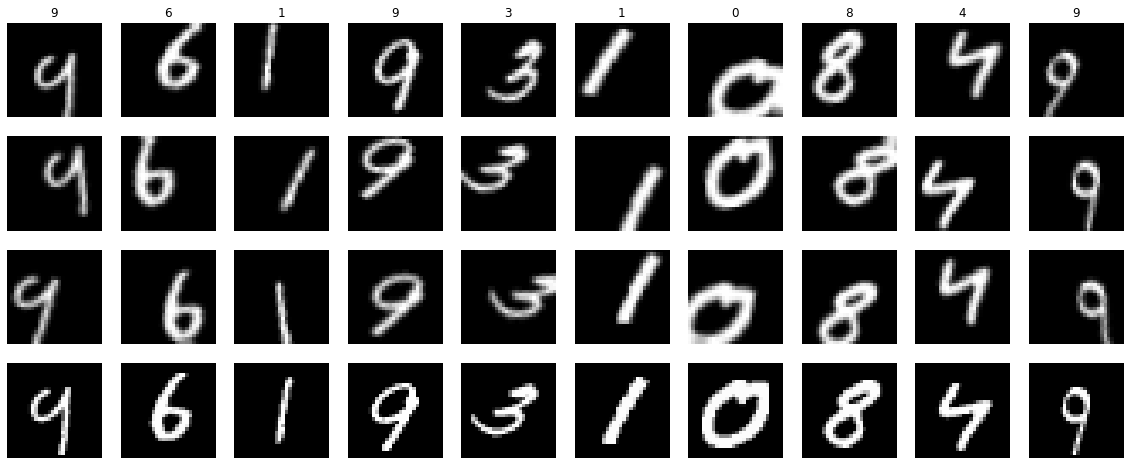

In [9]:
n_samples = 10
plt.figure(figsize=(20, 8))
for i in range(3):
    augmented_input_samples = transforms(X_train[:n_samples], training=True)
    for j, sample in enumerate(augmented_input_samples, 1):
        plt.subplot(4, n_samples, 10*i+j)
        if i == 0:
            plt.title(f"{y_train[j-1]}")
        plt.imshow(sample.numpy().squeeze(-1), cmap="gray")
        plt.axis("off")
for i in range(n_samples):
    plt.subplot(4, n_samples, 31+i)
    plt.imshow(X_train[i].squeeze(-1), cmap="gray")
    plt.axis("off")
plt.show()

In [10]:
transforms = Sequential(name="transforms_cross_nb")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="nearest"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="bilinear"))           # almost 20 degree
transforms.compile()

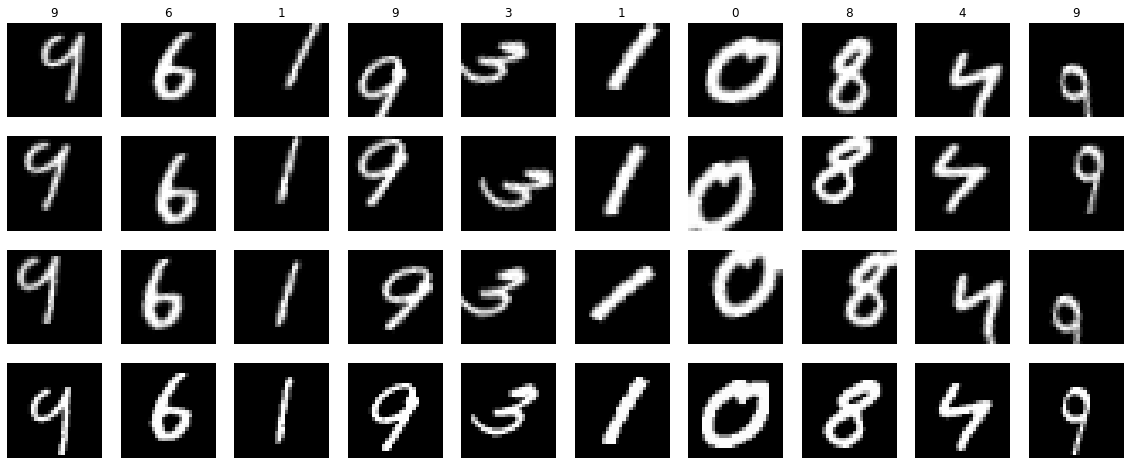

In [11]:
n_samples = 10
plt.figure(figsize=(20, 8))
for i in range(3):
    augmented_input_samples = transforms(X_train[:n_samples], training=True)
    for j, sample in enumerate(augmented_input_samples, 1):
        plt.subplot(4, n_samples, 10*i+j)
        if i == 0:
            plt.title(f"{y_train[j-1]}")
        plt.imshow(sample.numpy().squeeze(-1), cmap="gray")
        plt.axis("off")
for i in range(n_samples):
    plt.subplot(4, n_samples, 31+i)
    plt.imshow(X_train[i].squeeze(-1), cmap="gray")
    plt.axis("off")
plt.show()

In [12]:
transforms = Sequential(name="transforms_cross_bn")
transforms.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="bilinear"))    # 20%
transforms.add(RandomRotation(0.06, fill_mode="nearest", interpolation="nearest"))           # almost 20 degree
transforms.compile()

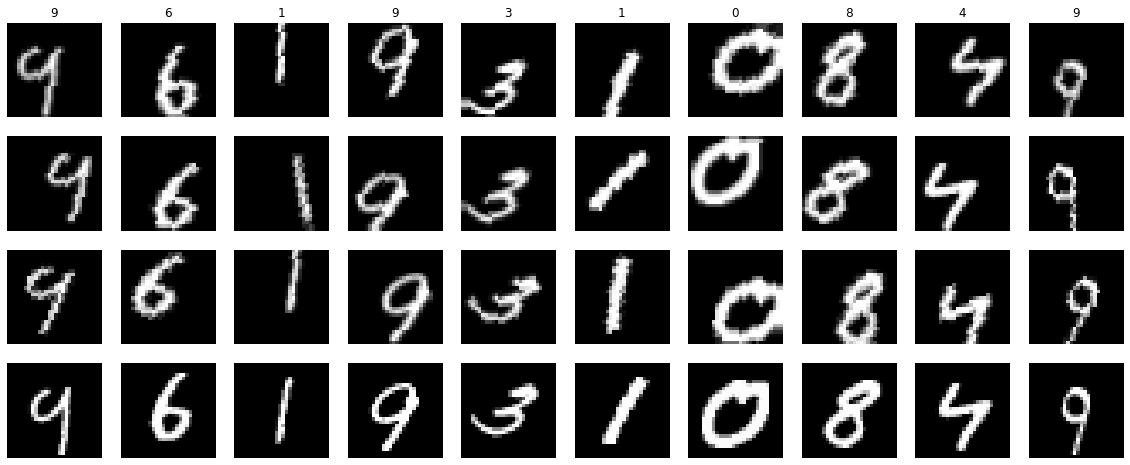

In [13]:
n_samples = 10
plt.figure(figsize=(20, 8))
for i in range(3):
    augmented_input_samples = transforms(X_train[:n_samples], training=True)
    for j, sample in enumerate(augmented_input_samples, 1):
        plt.subplot(4, n_samples, 10*i+j)
        if i == 0:
            plt.title(f"{y_train[j-1]}")
        plt.imshow(sample.numpy().squeeze(-1), cmap="gray")
        plt.axis("off")
for i in range(n_samples):
    plt.subplot(4, n_samples, 31+i)
    plt.imshow(X_train[i].squeeze(-1), cmap="gray")
    plt.axis("off")
plt.show()

In [14]:
X_train.shape, X_valid.shape

((54000, 28, 28, 1), (6000, 28, 28, 1))

### Modeling

In [15]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import InputLayer

tf.random.set_seed(33)
tf.random.set_seed(33)

In [16]:
preprocess = Sequential(name="shift_and_rotation")
preprocess.add(RandomTranslation(0.2, 0.2, fill_mode="nearest", interpolation="nearest"))    # 20%
preprocess.add(RandomRotation(0.06, fill_mode="nearest", interpolation="bilinear"))           # almost 20 degree

#### M3

In [17]:
# M3
model_M3 = Sequential(name="M3")
model_M3.add(InputLayer((28, 28, 1)))
model_M3.add(preprocess)
model_M3.add(Conv2D(filters=32,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=48,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=64,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=80,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=96,  kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=112, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=144, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=160, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Conv2D(filters=176, kernel_size=3, activation="relu"))
model_M3.add(BatchNormalization())
model_M3.add(Flatten())
model_M3.add(Dense(units=10))
model_M3.add(BatchNormalization())
model_M3.add(Softmax())

In [18]:
model_M3.summary()

Model: "M3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shift_and_rotation (Sequent  (None, 28, 28, 1)        0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 48)        13872     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 48)       192       
 hNormalization)                                                 
                                                                

#### M5

In [19]:
model_M5 = Sequential(name="M5")
model_M5.add(InputLayer((28, 28, 1)))
model_M5.add(preprocess)
model_M5.add(Conv2D(filters=32,  kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Conv2D(filters=64,  kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Conv2D(filters=96,  kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Conv2D(filters=128, kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Conv2D(filters=160, kernel_size=5, activation="relu"))
model_M5.add(BatchNormalization())
model_M5.add(Flatten())
model_M5.add(Dense(units=10))
model_M5.add(BatchNormalization())
model_M5.add(Softmax())

In [20]:
model_M5.summary()

Model: "M5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shift_and_rotation (Sequent  (None, 28, 28, 1)        0         
 ial)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 batch_normalization_11 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 batch_normalization_12 (Bat  (None, 20, 20, 64)       256       
 chNormalization)                                                
                                                                

#### M7

In [21]:
# M7
model_M7 = Sequential(name="M7")
model_M7.add(InputLayer((28, 28, 1)))
model_M7.add(preprocess)
model_M7.add(Conv2D(filters=48,  kernel_size=7, activation="relu"))
model_M7.add(BatchNormalization())
model_M7.add(Conv2D(filters=96,  kernel_size=7, activation="relu"))
model_M7.add(BatchNormalization())
model_M7.add(Conv2D(filters=144, kernel_size=7, activation="relu"))
model_M7.add(BatchNormalization())
model_M7.add(Conv2D(filters=192, kernel_size=7, activation="relu"))
model_M7.add(BatchNormalization())
model_M7.add(Flatten())
model_M7.add(Dense(units=10))
model_M7.add(BatchNormalization())
model_M7.add(Softmax())

In [22]:
model_M7.summary()

Model: "M7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shift_and_rotation (Sequent  (None, 28, 28, 1)        0         
 ial)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 22, 22, 48)        2400      
                                                                 
 batch_normalization_17 (Bat  (None, 22, 22, 48)       192       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 96)        225888    
                                                                 
 batch_normalization_18 (Bat  (None, 16, 16, 96)       384       
 chNormalization)                                                
                                                                

### Training
- transform 층을 모델 앞에 붙여 학습 진행 (evalution 시에는 transform 하지 않음)
- Hyperparameter
    - batch size = training 120, validation 100
    - initial learning_rate = 0.001
    - decay (beta_1) = 0.98
    - exponential moving average of weights
        - exponential decay = 0.999

In [23]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.98)
model_M3.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy", 
                metrics=["accuracy"])
history_M3 = model_M3.fit(X_train, y_train, 
                          epochs=150,
                          batch_size=120,
                          shuffle=True,
                          validation_data=(X_valid, y_valid),
                          validation_batch_size=100
                          )
model_M3.evaluate(X_test, y_test)

Epoch 1/150
450/450 [==============================] - 28s 43ms/step - loss: 0.7022 - accuracy: 0.8415 - val_loss: 2.7451 - val_accuracy: 0.2840
Epoch 2/150
450/450 [==============================] - 19s 42ms/step - loss: 0.2258 - accuracy: 0.9679 - val_loss: 0.1499 - val_accuracy: 0.9772
Epoch 3/150
450/450 [==============================] - 19s 43ms/step - loss: 0.1512 - accuracy: 0.9739 - val_loss: 0.1084 - val_accuracy: 0.9835
Epoch 4/150
450/450 [==============================] - 19s 43ms/step - loss: 0.1115 - accuracy: 0.9797 - val_loss: 0.0754 - val_accuracy: 0.9875
Epoch 5/150
450/450 [==============================] - 19s 43ms/step - loss: 0.0926 - accuracy: 0.9811 - val_loss: 0.0755 - val_accuracy: 0.9827
Epoch 6/150
450/450 [==============================] - 19s 42ms/step - loss: 0.0837 - accuracy: 0.9823 - val_loss: 0.0552 - val_accuracy: 0.9872
Epoch 7/150
450/450 [==============================] - 19s 42ms/step - loss: 0.0782 - accuracy: 0.9824 - val_loss: 0.0790 - val_ac

[0.021574126556515694, 0.9944999814033508]

In [24]:
history_M3.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
model_M5.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy", 
                 metrics=["accuracy"])
history_M5 = model_M5.fit(X_train, y_train, 
                          epochs=150,
                          batch_size=120,
                          shuffle=True,
                          validation_data=(X_valid, y_valid),
                          validation_batch_size=100
                          )
model_M5.evaluate(X_test, y_test)

Epoch 1/150
450/450 [==============================] - 12s 23ms/step - loss: 0.5659 - accuracy: 0.8703 - val_loss: 0.5744 - val_accuracy: 0.8662
Epoch 2/150
450/450 [==============================] - 10s 23ms/step - loss: 0.1706 - accuracy: 0.9671 - val_loss: 0.1378 - val_accuracy: 0.9795
Epoch 3/150
450/450 [==============================] - 10s 22ms/step - loss: 0.1153 - accuracy: 0.9760 - val_loss: 0.0632 - val_accuracy: 0.9853
Epoch 4/150
450/450 [==============================] - 10s 22ms/step - loss: 0.0884 - accuracy: 0.9813 - val_loss: 0.0635 - val_accuracy: 0.9882
Epoch 5/150
450/450 [==============================] - 10s 21ms/step - loss: 0.0754 - accuracy: 0.9832 - val_loss: 0.0726 - val_accuracy: 0.9820
Epoch 6/150
450/450 [==============================] - 10s 21ms/step - loss: 0.0650 - accuracy: 0.9847 - val_loss: 0.0607 - val_accuracy: 0.9847
Epoch 7/150
450/450 [==============================] - 10s 21ms/step - loss: 0.0643 - accuracy: 0.9843 - val_loss: 0.0591 - val_ac

[0.02014341950416565, 0.9951000213623047]

In [27]:
model_M7.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy", 
                 metrics=["accuracy"])
history_M7 = model_M7.fit(X_train, y_train, 
                          epochs=150,
                          batch_size=120,
                          shuffle=True,
                          validation_data=(X_valid, y_valid),
                          validation_batch_size=100
                          )
model_M7.evaluate(X_test, y_test)

Epoch 1/150
450/450 [==============================] - 12s 24ms/step - loss: 0.5834 - accuracy: 0.8571 - val_loss: 0.8061 - val_accuracy: 0.7253
Epoch 2/150
450/450 [==============================] - 11s 24ms/step - loss: 0.1862 - accuracy: 0.9596 - val_loss: 0.1063 - val_accuracy: 0.9832
Epoch 3/150
450/450 [==============================] - 11s 24ms/step - loss: 0.1280 - accuracy: 0.9704 - val_loss: 0.0730 - val_accuracy: 0.9852
Epoch 4/150
450/450 [==============================] - 11s 24ms/step - loss: 0.1007 - accuracy: 0.9763 - val_loss: 0.0578 - val_accuracy: 0.9848
Epoch 5/150
450/450 [==============================] - 11s 24ms/step - loss: 0.0876 - accuracy: 0.9785 - val_loss: 0.0674 - val_accuracy: 0.9843
Epoch 6/150
450/450 [==============================] - 11s 23ms/step - loss: 0.0756 - accuracy: 0.9809 - val_loss: 0.0459 - val_accuracy: 0.9888
Epoch 7/150
450/450 [==============================] - 11s 23ms/step - loss: 0.0689 - accuracy: 0.9824 - val_loss: 0.0543 - val_ac

[0.01939419098198414, 0.9955000281333923]

### Experiments

In [37]:
history = dict(
    M3=history_M3.history,
    M5=history_M5.history,
    M7=history_M7.history
)

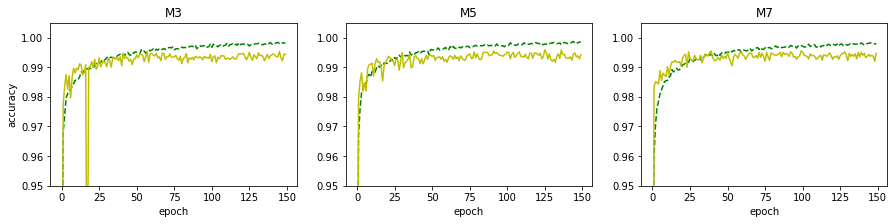

In [44]:
fig = plt.figure(figsize=(15, 3))
for i, (model_name, model_history) in enumerate(history.items()):
    plt.subplot(1, 3, i+1)
    plt.plot(model_history["accuracy"], "g--", label="training")
    plt.plot(model_history["val_accuracy"], "y-", label="validation")
    plt.xlabel("epoch")
    if i == 0:
        plt.ylabel("accuracy")
    else:
        plt.ylabel("")
    plt.title(f"{model_name}")
    plt.ylim(0.95, 1.005)
plt.show()

### Ensemble
- 논문에서는 initial weights를 다르게 해서 각 모델별로 1000개씩, 총 3000개를 학습시키고 앙상블 하여 최고 성적을 달성
- (모델링에 대한 실험에서는 10개씩 총 30개로)
- 여기서는 3개 모델에 대해서만 앙상블 해보기로
    - 단 3개의 모델이지만 accuracy 상승 (0.9965)



In [50]:
y_pred_M3 = model_M3.predict(X_test)
y_pred_M5 = model_M5.predict(X_test)
y_pred_M7 = model_M7.predict(X_test)

In [59]:
soft_voting = np.mean([y_pred_M3, y_pred_M5, y_pred_M7], axis=0)
soft_voting.shape

(10000, 10)

In [60]:
ensembled_pred = soft_voting.argmax(axis=-1)

In [61]:
from sklearn.metrics import accuracy_score

ensemble_accuracy = accuracy_score(y_test, ensembled_pred)
ensemble_accuracy

0.9965